<a href="https://colab.research.google.com/github/sarthakchauhan0/CIFAR10-Analysis/blob/main/Bayesian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler

# Set seed for reproducibility
np.random.seed(42)

# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Preprocess the images
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# Apply data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.15,
    shear_range=0.15
)

datagen.fit(X_train)

# Increase the number of PCA components
pca = PCA(n_components=200, random_state=42)
X_train_pca = pca.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_pca = pca.transform(X_test.reshape(X_test.shape[0], -1))

# Standardize the PCA features
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)

# Compute the mean and covariance matrix for each class
num_classes = 10
mean_vecs = []
cov_mats = []
alpha = 1e-5
for i in range(num_classes):
    X_i = X_train_pca[y_train[:, 0] == i]
    mean_vec = np.mean(X_i, axis=0)
    cov_mat = np.cov(X_i.T)
    cov_mat += alpha * np.eye(cov_mat.shape[0]) # Regularize the covariance matrix
    mean_vecs.append(mean_vec)
    cov_mats.append(cov_mat)

# Define the likelihood function
def likelihood(x, class_idx):
    return multivariate_normal.logpdf(x, mean=mean_vecs[class_idx], cov=cov_mats[class_idx])

# Define the prior probabilities
priors = np.bincount(y_train[:, 0]) / len(y_train)

# Classify the test images using Bayes' rule
y_pred = []
for i in range(X_test_pca.shape[0]):
    posteriors = []
    for j in range(num_classes):
        likelihood_j = likelihood(X_test_pca[i], j)
        posterior_j = likelihood_j + np.log(priors[j])
        posteriors.append(posterior_j)
    y_pred.append(np.argmax(posteriors))

# Compute the test accuracy
acc = np.mean(np.equal(y_test[:, 0], y_pred))
print('Test accuracy:', acc)

Test accuracy: 0.5217


In [4]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test[:, 0], y_pred)

# Print the confusion matrix
print('Confusion matrix:')
print(cm)


Confusion matrix:
[[485  37  47  42  73  14  12  19 215  56]
 [ 47 622   5  22   8  13  20  12 101 150]
 [ 69  14 326  76 226 121  58  34  41  35]
 [ 43  31  99 323 113 172  72  51  25  71]
 [ 39  20  69  58 581  61  43  77  29  23]
 [ 17  11 112 136 100 467  52  63   9  33]
 [ 23  34  75  71 152  52 526  11  21  35]
 [ 36  18  43  49 104  94  10 574  14  58]
 [ 69  70  27  22  17   9  11  14 709  52]
 [ 48 127  11  40  16  18  12  33  91 604]]


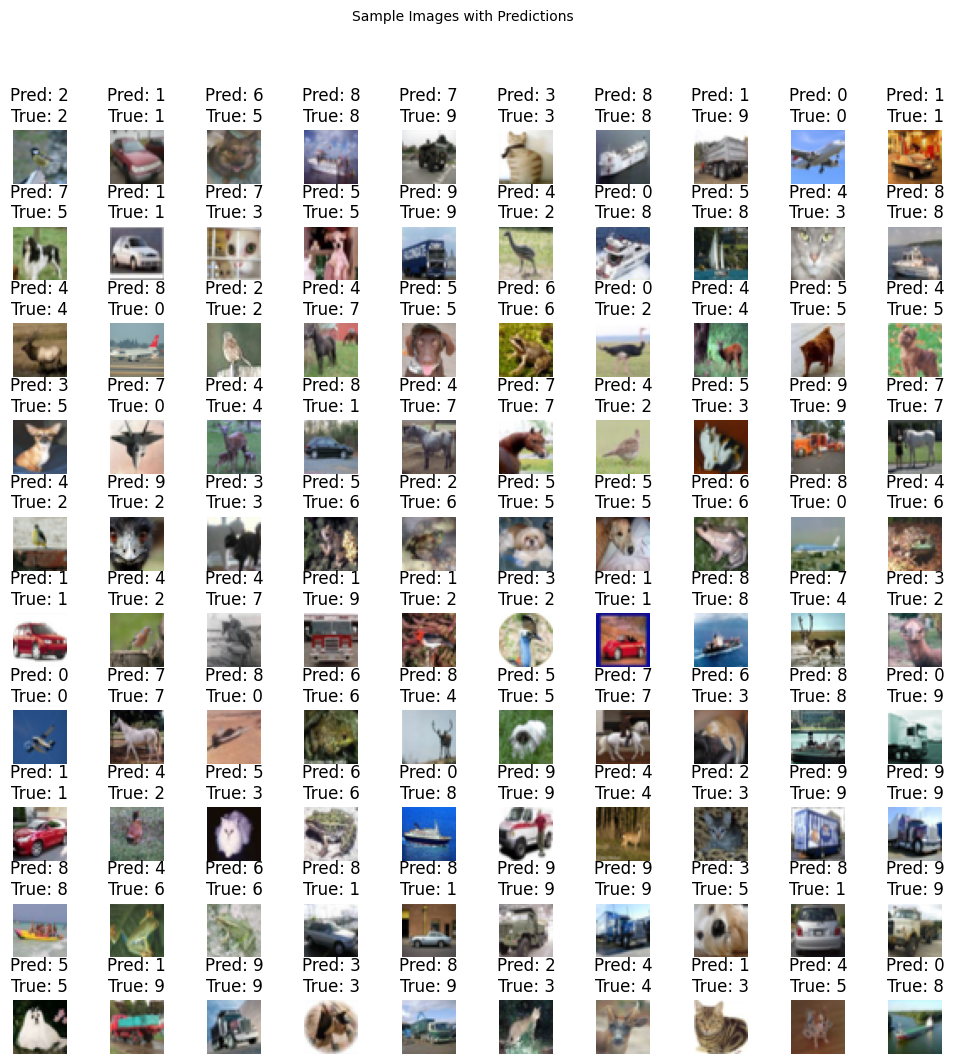

In [5]:
import matplotlib.pyplot as plt

# Get a random sample of 100 images from the test set
sample_indices = np.random.choice(np.arange(len(X_test)), size=100, replace=False)
sample_images = X_test[sample_indices]
sample_labels = y_test[sample_indices]

# Make predictions on the sample images
y_pred = []
for i in range(sample_images.shape[0]):
    posteriors = []
    for j in range(num_classes):
        likelihood_j = likelihood(X_test_pca[sample_indices[i]], j)
        posterior_j = likelihood_j + np.log(priors[j])
        posteriors.append(posterior_j)
    y_pred.append(np.argmax(posteriors))

# Create a 10x10 grid of subplots
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(12, 12))
fig.suptitle('Sample Images with Predictions', fontsize=10)
fig.subplots_adjust(hspace=0.8, wspace=0.8)

# Populate the grid with images and their predicted labels
for i in range(10):
    for j in range(10):
        idx = i * 10 + j
        ax[i, j].imshow(sample_images[idx].reshape(32, 32, 3))
        ax[i, j].axis('off')
        predicted_label = y_pred[idx]
        true_label = sample_labels[idx][0]
        ax[i, j].set_title(f'Pred: {predicted_label}\nTrue: {true_label}')

plt.show()
